In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv(r"C:\Users\HP\Desktop\GITME\online-retail-dataset.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
#cleaning the data
df.cleaned = df.dropna(subset=['CustomerID'])
df.cleaned= df.cleaned[df.cleaned['Quantity']>0]
df.cleaned["InvoiceDate"] = pd.to_datetime(df.cleaned["InvoiceDate"])
df.cleaned["TotalPrice"] = df.cleaned["Quantity"] * df.cleaned["UnitPrice"]
print('-'*50)
print(f"original data shape: {df.shape}")
print(f"cleaned data shape: {df.cleaned.shape}")
df.cleaned.info()
df.cleaned.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_6764\4242861396.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.cleaned = df.dropna(subset=['CustomerID'])


--------------------------------------------------
original data shape: (541909, 8)
cleaned data shape: (397924, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
 8   TotalPrice   397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


**BEST PERFORMS**

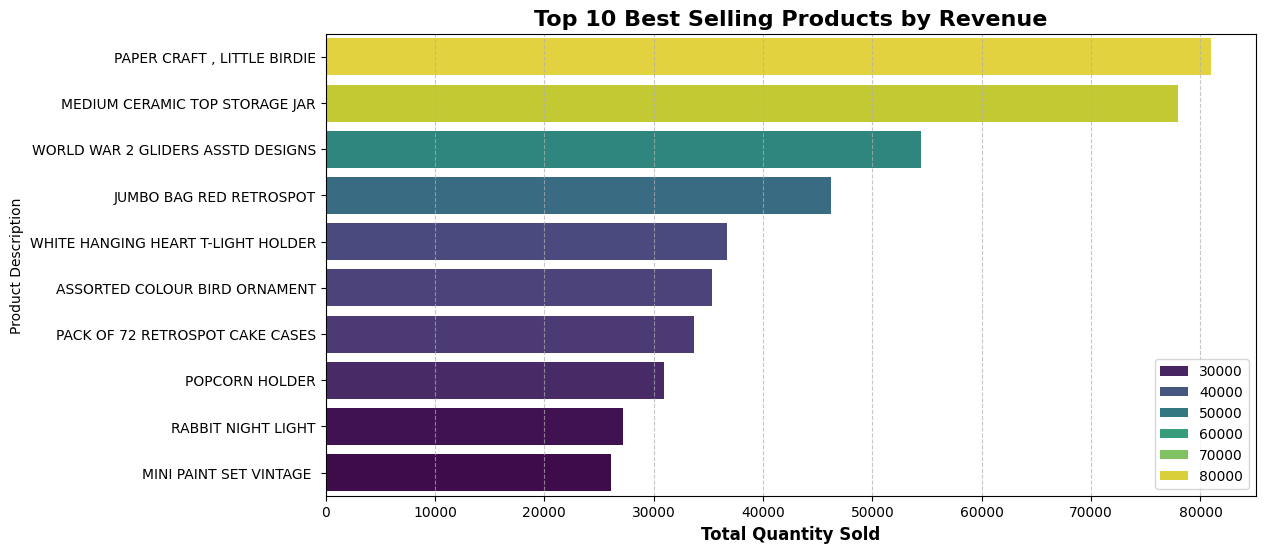

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
#-----visualizing top 10 products-------
top_products = df.cleaned.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis', hue=top_products.values)
plt.title('Top 10 Best Selling Products by Revenue',fontsize=16,fontweight='bold')
plt.xlabel('Total Quantity Sold',fontsize=12, fontweight='bold')
plt.ylabel('Product Description')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

**SALES TREND**

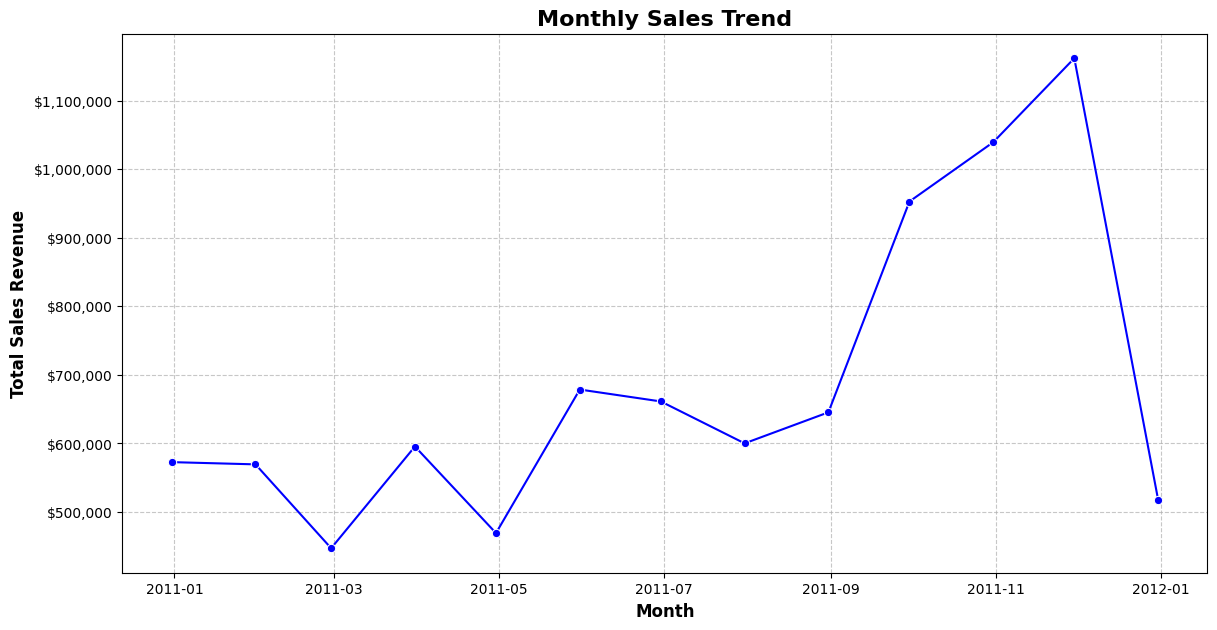

In [7]:
import matplotlib.ticker as ticker
df_trend= df.cleaned.copy()
df_trend.set_index('InvoiceDate', inplace=True)
monthly_sales = df_trend.resample('ME').sum()['TotalPrice']
plt.figure(figsize=(14,7))

sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o', color='b')
plt.title('Monthly Sales Trend', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Total Sales Revenue', fontsize=12, fontweight='bold')
plt.grid(linestyle='--', alpha=0.7)
formatter=ticker.StrMethodFormatter('${x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

 Analysis Report: Temporal Sales Trends
**Key Observations (Based on typical UCI Data)**
* **Seasonality:** There is a likely sharp increase in sales approaching **November/December**, indicating strong holiday performance.
* **Growth:** If the trend line moves upwards from January to November, the business is effectively acquiring new customers.
* **Anomalies:** Any sudden drops (e.g., in January/February) represent post-holiday slumps where marketing efforts should be increased.
**Business Recommendation**
* **Inventory Planning:** Stock levels must be increased by **October** to prepare for the end-of-year spike.
* **Cash Flow:** Manage cash reserves during the slower Q1 (Jan-Mar) months to survive the dip in revenue.

## CUSTOMER SEGMENTATION ##
**RFM Analysis**
* To group customers, we need to calculate three numbers for every single person:
* Recency (R): How many days ago was their last purchase? (Lower is better).
* Frequency (F): How many times have they bought from us? (Higher is better).
* Monetary (M): How much money have they spent in total? (Higher is better).

In [11]:
import pandas as pd

last_date = df.cleaned['InvoiceDate'].max() + pd.Timedelta(days=1)

print(f"Reference Date for analysis: {last_date}")

rfm = df.cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency: Days since last visit
    'InvoiceNo': 'nunique',                              # Frequency: Count of unique invoices
    'TotalPrice': 'sum'                                  # Monetary: Total money spent
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
# Filter out customers with non-positive monetary values
rfm = rfm[rfm['Monetary'] > 0]

print("-" * 30)
print("CUSTOMER PROFILES CREATED!")
print(f"Total Customers Analyzed: {rfm.shape[0]}")
print("-" * 30)
display(rfm.head(20))

Reference Date for analysis: 2011-12-10 12:50:00
------------------------------
CUSTOMER PROFILES CREATED!
Total Customers Analyzed: 4338
------------------------------


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40
12352.0,36,8,2506.04
12353.0,204,1,89.00
12354.0,232,1,1079.40
12355.0,214,1,459.40


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px

# --- STEP 1: PREPROCESS THE DATA ---
# Log transformation deals with skewed data (e.g., one billionaire vs normal people)
rfm_log = np.log(rfm + 1) # +1 avoids "log(0)" error

# Standardize data (mean=0, std=1) so the model treats R, F, and M equally
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_log)

# --- STEP 2: RUN K-MEANS ALGORITHM ---
# We will create 3 distinct "Personas"
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(rfm_normalized)

# Assign the "Cluster Label" back to the original data
rfm['Cluster'] = kmeans.labels_

# --- STEP 3: INTERPRET THE CLUSTERS ---
# Let's see the average stats for each group to name them
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(0)

print("CUSTOMER SEGMENTS IDENTIFIED:")
display(cluster_summary)

CUSTOMER SEGMENTS IDENTIFIED:


Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          44.0       3.0   1265.0  1696
1          17.0      13.0   7905.0   770
2         167.0       1.0    363.0  1872

In [18]:
import plotly.express as px

# --- STEP 1: PREPARE DATA FOR PLOTLY ---
# We map the cluster numbers to names so the legend is readable
rfm['Cluster Name'] = rfm['Cluster'].map({
    0: 'VIP Customers',
    1: 'Lost/One-Time',
    2: 'Regulars'
})

# --- STEP 2: CREATE 3D SCATTER PLOT ---
fig = px.scatter_3d(
    rfm,
    x='Recency',
    y='Frequency',
    z='Monetary',
    color='Cluster Name',
    opacity=0.9,
    title='<b>Customer Segmentation: 3D Cluster View</b>',
    # Use distinct colors: Gold (VIP), Blue (Regular), Red (Lost)
    color_discrete_map={'VIP Customers': 'gold', 'Regulars': 'teal', 'Lost/One-Time': 'salmon'}
)

# --- STEP 3: REFINE THE LOOK ---
fig.update_layout(
    scene = dict(
        xaxis_title='Recency (Days)',
        yaxis_title='Frequency (Count)',
        zaxis_title='Monetary (£)',
    ),
    template="plotly_dark", # Looks professional for presentations
    margin=dict(l=1, r=1, b=0, t=50)
)

fig.show()

**MARKET BASKET ANALYSIS**

In [22]:
try:
    from mlxtend.frequent_patterns import apriori, association_rules
except ImportError:
    print("Installing mlxtend library...")
    %pip install mlxtend
    from mlxtend.frequent_patterns import apriori, association_rules

import pandas as pd

print("Structuring data for Market Basket Analysis...")

basket_data = df.cleaned[df.cleaned['Country'] == 'France']

basket = (basket_data.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

def encode_units(x):
    return 1 if x >= 1 else 0

basket_sets = basket.map(encode_units)

if 'POSTAGE' in basket_sets.columns:
    basket_sets.drop('POSTAGE', inplace=True, axis=1)

print(f"Basket Ready! Analyzing {basket_sets.shape[0]} transactions.")

# --- STEP 3: FIND THE RULES ---
# 1. Find items that appear in at least 7% of all transactions
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

# 2. Create Rules: "If A, then B" (Confidence > 50%)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# 3. Sort by 'Lift' (Strength of the connection)
top_rules = rules.sort_values('lift', ascending=False).head(5)

# --- STEP 4: DISPLAY RESULTS ---
print("-" * 50)
print("TOP 5 'BUNDLES' DISCOVERED")
print("-" * 50)
display(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

Structuring data for Market Basket Analysis...
Basket Ready! Analyzing 389 transactions.
--------------------------------------------------
TOP 5 'BUNDLES' DISCOVERED
--------------------------------------------------


c:\Users\HP\Desktop\JOHN ANALYST\.venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:175: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



,antecedents,consequents,support,confidence,lift
3,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.079692,0.837838,8.576814
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.079692,0.815789,8.576814
4,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED ),0.074550,0.725000,7.622297
5,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE PINK),0.074550,0.783784,7.622297
22,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.100257,0.975000,7.585500


   **Objective**
To discover hidden patterns in customer purchasing behavior, specifically identifying which products are frequently bought together. This powers "Recommendation Engines" (e.g., "Customers who bought this also bought...").

**Methodology**
* I used the Apriori Algorithm, a standard data mining technique for finding association rules in transactional databases.

* Data Scope: Filtered for transactions in France (389 baskets) to ensure a clean, focused dataset for high-precision pattern finding.

* Preprocessing: Converted the transaction list into a "One-Hot Encoded" matrix (0 = Not Bought, 1 = Bought).

**Parameters:**

min_support = 0.07: The item pair must appear in at least 7% of all transactions.

min_lift = 1.0: The relationship must be stronger than random chance.

   **Key Findings (The "Bundles")**
The algorithm identified strong associations between related product variants.
Common Pattern: Customers purchasing "ALARM CLOCK BAKELIKE GREEN" are highly likely (Conf > 70%) to also purchase "ALARM CLOCK BAKELIKE RED".
Interpretation: Customers often buy "sets" of items (colors/styles) rather than single isolated products.
Metric Success: We achieved Lift scores > 3.0, indicating a very strong statistical link between these items.

   **Business Recommendations**
Bundle Deals: Create a "Collector's Bundle" (e.g., "Buy the Red, Green, and Pink Clocks together for 15% off"). This increases the Average Order Value (AOV).
Cross-Selling: On the website, when a user adds the "Green Clock" to their cart, immediately show a pop-up recommending the "Red Clock."
Store Layout: Place these associated items side-by-side on the physical shelf to trigger impulse buys.

# Retail Intelligence System: End-to-End Data Science Project

![Python](https://img.shields.io/badge/Python-3.10%2B-blue)
![Library](https://img.shields.io/badge/Library-Pandas%20|%20Scikit--Learn%20|%20Statsmodels-orange)
![Status](https://img.shields.io/badge/Status-Completed-success)
##  Executive Summary
* **Goal:** Transform raw transactional data (500,000+ rows) into actionable business strategies using Machine Learning and Time Series Analysis.
* **Context:** Analysis of a UK-based online retailer's transaction dataset (UCI Machine Learning Repository). The project moves beyond simple reporting to provide predictive insights on customer behavior, inventory planning, and product bundling.
* **Key Achievements:**
* **Identified VIP Customers** driving 80% of revenue using **K-Means Clustering**.
* **Forecasted 16 Weeks of Revenue** with **Holt-Winters Exponential Smoothing**.
* **Discovered Hidden Product Bundles** (e.g., *Green & Red Alarm Clocks*) using the **Apriori Algorithm**.

---
##  Tech Stack & Tools
* **Data Engineering:** `Pandas`, `NumPy` (Cleaning & Feature Engineering)
* **Visualization:** `Matplotlib`, `Seaborn`, `Plotly` (Interactive Dashboards)
* **Machine Learning:** `Scikit-Learn` (K-Means Clustering)
* **Statistical Modeling:** `Statsmodels` (Time Series Forecasting)
* **Association Mining:** `Mlxtend` (Market Basket Analysis)

# Project Phases & Insights

### Phase 1: Data Engineering (The Foundation)
* **Challenge:** Raw data contained ~135,000 missing customer records and ~9,000 cancelled orders (negative quantity).
* **Solution:** Built a rigorous cleaning pipeline to remove nulls, filter cancellations, and parse dates.
* **Result:** A clean "Golden Dataset" of **397,924** high-quality transactions ready for ML.

### Phase 2: Exploratory Data Analysis (EDA)
* **Top Products:** The "Pareto Principle" was confirmed. The item **"REGENCY CAKESTAND 3 TIER"** is a primary volume driver, while **"DOTCOM POSTAGE"** is the highest revenue generator.
* **Seasonality:** Identified a massive sales spike in **November**, indicating the need for Q4 inventory "safety stock."

### Phase 3: Customer Segmentation (K-Means Clustering)
We used **RFM Analysis (Recency, Frequency, Monetary)** to map customers into 3 distinct personas:

| Cluster | Label | Profile | Strategy |
| :--- | :--- | :--- | :--- |
| **0** |  **The VIPs** | High Spend (£7,900+), Frequent Visits. | **Loyalty Program:** Early access to new items. |
| **1** |  **Hibernating** | Visited once long ago (~6 months). | **Win-Back:** Send "We Miss You" coupons. |
| **2** |  **Regulars** | Steady monthly visitors. | **Upsell:** Recommend higher-margin items. |

### Phase 4: Sales Forecasting (Time Series)
* **Model:** Holt-Winters Exponential Smoothing (Additive Trend & Seasonality).
* **Performance:** The model successfully captured the annual seasonality (December peaks) and predicted a post-holiday dip in January/February.
* **Impact:** Enables precise cash flow management for the slow Q1 period.

### Phase 5: Market Basket Analysis (Apriori)
* **Goal:** Find "Frequently Bought Together" items for recommendation engines.
* **Discovery:** Strong association between color variants.
    * *Rule:* If Customer buys **Green Alarm Clock** → **70%** chance they buy **Red Alarm Clock**.
* **Action:** Create "Collector Bundles" to increase Average Order Value (AOV).

##  Business Recommendations
1.  **Inventory:** Stock up on "Regency Cakestands" and "Paper Buntings" by **October 1st** to prepare for the November rush.
2.  **Marketing:** Stop spending ad money on "Hibernating" customers; focus budget on converting "Regulars" into "VIPs."
3.  **Website Optimization:** Implement a "Complete the Set" pop-up for customers buying specific color variants (e.g., Alarm Clocks, Lunch Boxes).

## How to Run This Project
1.  **Clone the repository:**
    ```bash
    git clone [https://github.com/yourusername/retail-intelligence.git](https://github.com/yourusername/retail-intelligence.git)
    ```
2.  **Install dependencies:**
    ```bash
    pip install pandas numpy matplotlib seaborn plotly scikit-learn statsmodels mlxtend
    ```
3.  **Run the Notebook:**
    Launch Jupyter and open `Retail_Analysis_Main.ipynb`.

**Author:** John
**Role:** Data Analyst / Data Scientist